In [20]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import os
import random
from tensorflow_examples.models.pix2pix import pix2pix


In [21]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [22]:
path = 'plant_segmentation/dataset/arabidopsis/*/*'
imagepath = 'plant_segmentation/dataset/arabidopsis/images/*'
maskspath = 'plant_segmentation/dataset/arabidopsis/masks/'

In [23]:
heigh = 256

In [24]:
#get name of image to find mask for it
def get_mask(image):
   return tf.strings.split(image,os.path.sep)[-1]

#load images and masks from path
def process_image_with_mask(file_path):
      img = tf.io.read_file(file_path)
      img = tf.image.decode_png(img)
      mask = maskspath + get_mask(file_path)
      mask = tf.io.read_file(mask)
      mask = tf.image.decode_png(mask)
      return img,mask

#load images without masks from path
def process_image(file_path):
   img = tf.io.read_file(file_path)
   img = tf.image.decode_png(img)
   img = tf.image.resize(img, (heigh, heigh), method="nearest")
   img = tf.cast(img, np.float32) / 255.0
   img = img[:,:,:3]
   print(img.shape)
   return img

#resize to heigh
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (heigh, heigh), method="nearest")
   input_mask = tf.image.resize(input_mask, (heigh, heigh), method="nearest")
   return input_image, input_mask

#augmentation 1
def flip_leftright(input_image, input_mask):
   input_image = tf.image.flip_left_right(input_image)
   input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

#augmentation 2
def flip_updown(input_image, input_mask):
   input_image = tf.image.flip_up_down(input_image)
   input_mask = tf.image.flip_up_down(input_mask)
   return input_image, input_mask

#augmentation 3
def rotation(input_image, input_mask):
   input_image = tf.image.rot90(input_image)
   input_mask = tf.image.rot90(input_mask)
   return input_image, input_mask

#augmentation 4
def crop(input_image, input_mask):
   seed = random.random()*10000
   input_image = tf.image.random_crop(input_image,size = (heigh*4,heigh*4,3),seed=int(seed))
   input_mask = tf.image.random_crop(input_mask,size = (heigh*4,heigh*4,1),seed=int(seed))
   return input_image, input_mask

#normalize mask and image
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, np.float32) / 255.0
   input_mask = tf.cast(input_mask, np.int16)
   return input_image, input_mask

def tf_dataset(imagepath,learning):
   dataset = tf.data.Dataset.list_files(imagepath)
   if learning:
      dataset = dataset.map(process_image_with_mask)
      datasetaugment = dataset.map(flip_leftright)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(flip_updown)
      dataset = dataset.concatenate(datasetaugment)
      datasetaugment = dataset.map(rotation)
      dataset = dataset.concatenate(datasetaugment)
      dataset = dataset.map(crop)
      dataset = dataset.map(resize)
      dataset = dataset.map(normalize)
      dataset = dataset.shuffle(128)
   else:
      dataset = dataset.map(process_image)
      dataset = dataset.batch(1)
   return dataset

In [25]:
dataset = tf_dataset(imagepath,learning = True)
dataset
valdataset = tf_dataset(imagepath,learning = True)
valdataset = valdataset.batch(4)

In [26]:
len(dataset)

128

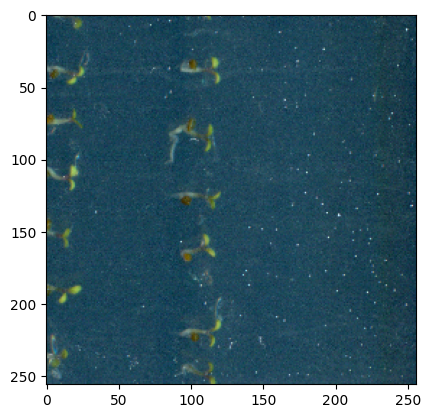

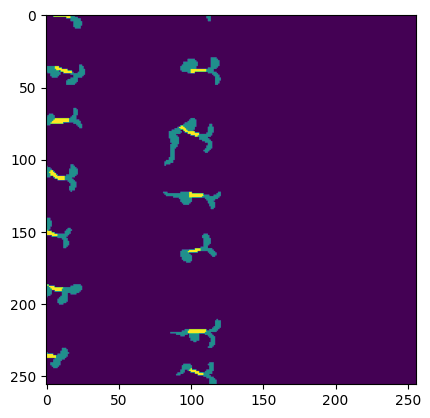

In [27]:
for image,mask in dataset.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask))

In [28]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
# def double_conv_block(x, n_filters):
#    # Conv2D then ReLU activation
#    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
#    # Conv2D then ReLU activation
#    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
#    return x

# def downsample_block(x, n_filters):
#    f = double_conv_block(x, n_filters)
#    p = layers.MaxPool2D(2)(f)
#    p = layers.Dropout(0.3)(p)
#    return f, p

# def upsample_block(x, conv_features, n_filters):
#    # upsample
#    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
#    # concatenate
#    x = layers.concatenate([x, conv_features])
#    # dropout
#    x = layers.Dropout(0.3)(x)
#    # Conv2D twice with ReLU activation
#    x = double_conv_block(x, n_filters)
#    return x

# def build_unet_model():
#    inputs = layers.Input(shape=(heigh,heigh,3))

#    # encoder: contracting path - downsample
#    # 1 - downsample
#    f0, p0 = downsample_block(inputs, 32)

#    f1, p1 = downsample_block(p0, 64)
#    # 2 - downsample
#    f2, p2 = downsample_block(p1, 128)
#    # 3 - downsample
#    f3, p3 = downsample_block(p2, 256)
#    # 4 - downsample
#    f4, p4 = downsample_block(p3, 512)

#    # 5 - bottleneck
#    bottleneck = double_conv_block(p4, 1024)

#    # decoder: expanding path - upsample
#    # 6 - upsample
#    u6 = upsample_block(bottleneck, f4, 512)
#    # 7 - upsample
#    u7 = upsample_block(u6, f3, 256)
#    # 8 - upsample
#    u8 = upsample_block(u7, f2, 128)
#    # 9 - upsample
#    u9 = upsample_block(u8, f1, 64)

#    u10 = upsample_block(u9, f0, 32)

#    # outputs
#    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u10)

#    # unet model with Keras Functional API
#    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

#    unet_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')

#    return unet_model

#model = build_unet_model()

In [39]:
model_history = model.fit(dataset.batch(4).repeat(),
                              epochs=8,
                              steps_per_epoch=16,
                              validation_data=valdataset,
                              validation_steps=4)

Epoch 1/8
16/16 [==============================] - 19s 652ms/step - loss: 0.0954 - accuracy: 0.9636 - val_loss: 0.0982 - val_accuracy: 0.9623
Epoch 2/8
16/16 [==============================] - 10s 657ms/step - loss: 0.0882 - accuracy: 0.9664 - val_loss: 0.0886 - val_accuracy: 0.9657
Epoch 3/8
16/16 [==============================] - 19s 651ms/step - loss: 0.0894 - accuracy: 0.9658 - val_loss: 0.0951 - val_accuracy: 0.9634
Epoch 4/8
16/16 [==============================] - 10s 678ms/step - loss: 0.0820 - accuracy: 0.9694 - val_loss: 0.0899 - val_accuracy: 0.9644
Epoch 5/8
16/16 [==============================] - 19s 647ms/step - loss: 0.0777 - accuracy: 0.9702 - val_loss: 0.0765 - val_accuracy: 0.9691
Epoch 6/8
16/16 [==============================] - 10s 683ms/step - loss: 0.0836 - accuracy: 0.9683 - val_loss: 0.0747 - val_accuracy: 0.9710
Epoch 7/8
16/16 [==============================] - 18s 635ms/step - loss: 0.0796 - accuracy: 0.9694 - val_loss: 0.0817 - val_accuracy: 0.9684
Epoch 

In [43]:
test = tf_dataset('cropped/AAE_0084.png',learning=False)
test

(256, 256, None)


<BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None)>

In [44]:
pred_mask = model.predict(test)

1/1 [==============================] - 0s 218ms/step


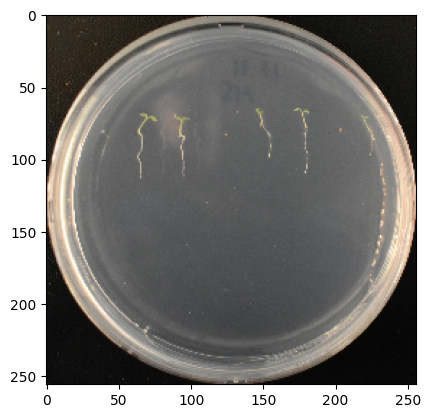

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


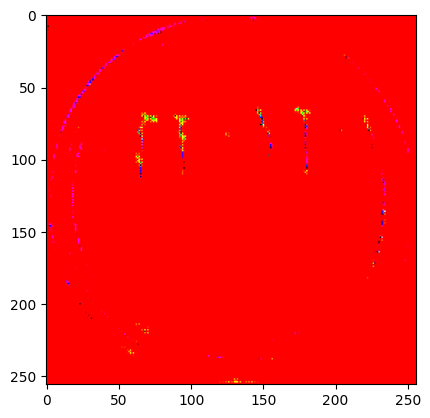

In [46]:
for i,image in enumerate(test.take(120)):
    plt.imshow(tf.keras.utils.array_to_img(image[0]))
    plt.pause(1)
    plt.imshow(pred_mask[i,:,:,:])

In [34]:
pred_mask.shape

(1, 256, 256, 3)